**The Notebook contains the code for Building Neural Network with the MNIST data**

- **Target of Book**: As the previous architecture ("slimer_trimmed.ipynb") has less number of parameters(lighter model) and is been performing consistent of 99.3/99,4 accuracy, we could think of making this model more robust using augmentation/GAP Layer with the perfomance. So, here the lighter model architecture involving special features & functionalities is being designed to achieve an accuracy in between 99.4% by less proning to over-fitting.

* **Description**: 

1. The network architecture is built up on involving special features.

2. This network has been reduced to usage of lesser number of parameters (8842) ~ 8 thousand parameter, which makes it a lighter model. 

3. The Architecture only has Convolutions, Relu activation function, Max Pooling, and returning result with softmax, which returns a list of probabilites of classes and will contain either of (BatchNormalization, Dropouts, Augmentations, GAP Layers).

4. The **Receptive Field looks out a 36x36** at the end.

5.  **EPOCHS**: Iterated the dataset for **15** times.
6. BATCHSIZE : 128 

7. Accuracies are mentioned in the "Results" section and "analysis" is made.

8. As per my view & visualizations, the model's accuracy has been great compared to previous architecture it starts with underfitted accuracies and regain the good accuracy score.


**A. Importing Libraries**

In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms

**B. Dataloader/ Loading the data**




In [2]:
# Defining transformations such that our data can be transformed in such a way 

train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
train = datasets.MNIST("./data",train=True,download=True,transform=train_transforms)
test = datasets.MNIST("./data",train=False,download=True,transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**C. Setting Configurations for processors & dataloading**

In [4]:
SEED = 1 
gpu = torch.cuda.is_available()
print("Is cuda available: ",gpu)
torch.manual_seed(SEED)

if gpu:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if gpu else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Is cuda available:  True


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



**D. Visualization & understanding of Images**

torch.Size([128, 1, 28, 28]) torch.Size([128])


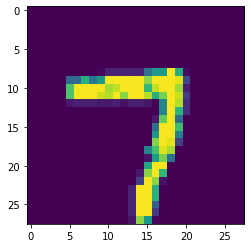

In [5]:
images,labels = next(iter(train_loader))
print(images.shape,labels.shape)
plt.imshow(images[10].numpy().squeeze())

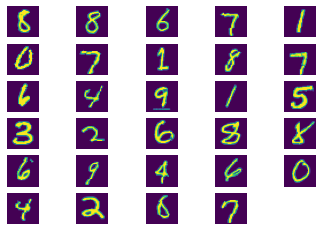

In [6]:
figure = plt.figure() 
for idx in range(1,30):
  plt.subplot(6,5,idx)
  plt.axis('off')
  plt.imshow(images[idx].numpy().squeeze())

**E. Building Model Architecture**

In [12]:
## creating Neural Network Architecture

class Setup(nn.Module):
  def __init__(self):
    super(Setup,self).__init__()

    
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU())
    # RF: 3*3
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=10,kernel_size=(3,3)),
        nn.BatchNorm2d(10),
        nn.ReLU()) 
    # RF: 5*5
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3)),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    # RF: 7*7
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=20,kernel_size=(3,3)),
        nn.BatchNorm2d(20),
        nn.ReLU()
    )
    # pool -> RF: 14*14  , Conv->RF: 16*16
    self.convblock6 = nn.Sequential(
       nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1)),
       nn.BatchNorm2d(10),
       nn.ReLU())
    # RF: 18*18
    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3)),
        nn.BatchNorm2d(16),
        nn.ReLU())
    # pool->RF: 36*36 , RF: 38*38
    self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(3,3)))
    # RF: 40*40
    self.pool1 = nn.MaxPool2d(2,2)
    self.dropout1 = nn.Dropout(0.1)

  def forward(self,x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)
    x = self.convblock5(x)
    x = self.dropout1(x)
    x = self.convblock6(x)
    x = self.pool1(x)
    x = self.dropout1(x)
    x = self.convblock7(x)
    x = self.convblock8(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

**F.Understanding the summary of Architecture**

In [13]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Setup().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 10, 26, 26]             730
       BatchNorm2d-5           [-1, 10, 26, 26]              20
              ReLU-6           [-1, 10, 26, 26]               0
            Conv2d-7           [-1, 16, 24, 24]           1,456
       BatchNorm2d-8           [-1, 16, 24, 24]              32
              ReLU-9           [-1, 16, 24, 24]               0
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           2,900
      BatchNorm2d-12           [-1, 20, 10, 10]              40
             ReLU-13           [-1, 20, 10, 10]               0
          Dropout-14           [-1

### Model Design: 

1. Block1: Image = (28,28) with padding makes Image = (30,30)  
           Parameters = (3*3*1+1)*8 = 8*10 = 80 
           Output Image = (28,28) 
           Receptive Field = (3,3) 
2. Block2: Image = Block1 output Image: (28,28) 
           Paramters = (3*3*8+1)*10 = 73*10 = 730
           OutputImage = (26,26) 
           Receptive Field = (5,5)

3. Block3: Image = Block2 ouptut Image (26,26) 
           Paramters = (3*3*10+1)*16 = 91*16 = 1456
           OutputImage = (24,24) 
           Receptive Field = (7,7)
           
**Pooling Layer**:
           Output Image = (12,12)
           Receptive Field = (14,14)

4. Block5: Image = Block3 ouptut Image (12,12) 
           Paramters = (3*3*16+1)*20 = 145*20 = 2900
           OutputImage = (10,10)
           Receptive Field = (16,16)
           
5. Block6: Image = Block5 ouptut Image (10,10) 
           Paramters = (3*3*20+1)*10 = 181*10 = 1810
           OutputImage = (10,10)
           Receptive Field = (16,16)
           
**Pooling Layer**:
           Output Image = (5,5)
           Receptive Field = (32,32)
        

6. Block7: Image = Block6 ouptut Image (3,3) 
           Paramters = (3*3*10+1)*16 = 91*16 = 1456
           OutputImage = (3,3) 
           Receptive Field = (34,34)
 

7. Block8: Image = Block7 ouptut Image (3,3) 
           Paramters = (3*3*16+1)*10 = 145*10 = 1450
           OutputImage = (3,3) 
           Receptive Field = (36,36)
 


**G. Defining & deriving the training & its results as well as test/validation results**

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples

    data, target = data.to(device), target.to(device)
  
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} train-Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, val-Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model =  Setup().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04615488275885582 Batch_id=468 train-Accuracy=92.22: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s] 



Test set: Average loss: 0.0635, val-Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.028722597286105156 Batch_id=468 train-Accuracy=97.58: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0421, val-Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.06759335100650787 Batch_id=468 train-Accuracy=98.04: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s] 



Test set: Average loss: 0.0404, val-Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.04135778918862343 Batch_id=468 train-Accuracy=98.25: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s] 



Test set: Average loss: 0.0304, val-Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.04435369744896889 Batch_id=468 train-Accuracy=98.44: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s] 



Test set: Average loss: 0.0287, val-Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.018908778205513954 Batch_id=468 train-Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0296, val-Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.03426496312022209 Batch_id=468 train-Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]  



Test set: Average loss: 0.0246, val-Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.004828727804124355 Batch_id=468 train-Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s] 



Test set: Average loss: 0.0271, val-Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.05766027793288231 Batch_id=468 train-Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]  



Test set: Average loss: 0.0291, val-Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.06919563561677933 Batch_id=468 train-Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]  



Test set: Average loss: 0.0280, val-Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.028225446119904518 Batch_id=468 train-Accuracy=98.91: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s] 



Test set: Average loss: 0.0238, val-Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.025571586564183235 Batch_id=468 train-Accuracy=98.89: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s] 



Test set: Average loss: 0.0245, val-Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.02235807292163372 Batch_id=468 train-Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]  



Test set: Average loss: 0.0219, val-Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.07939841598272324 Batch_id=468 train-Accuracy=99.00: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]  



Test set: Average loss: 0.0195, val-Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.02841869927942753 Batch_id=468 train-Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]  



Test set: Average loss: 0.0192, val-Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

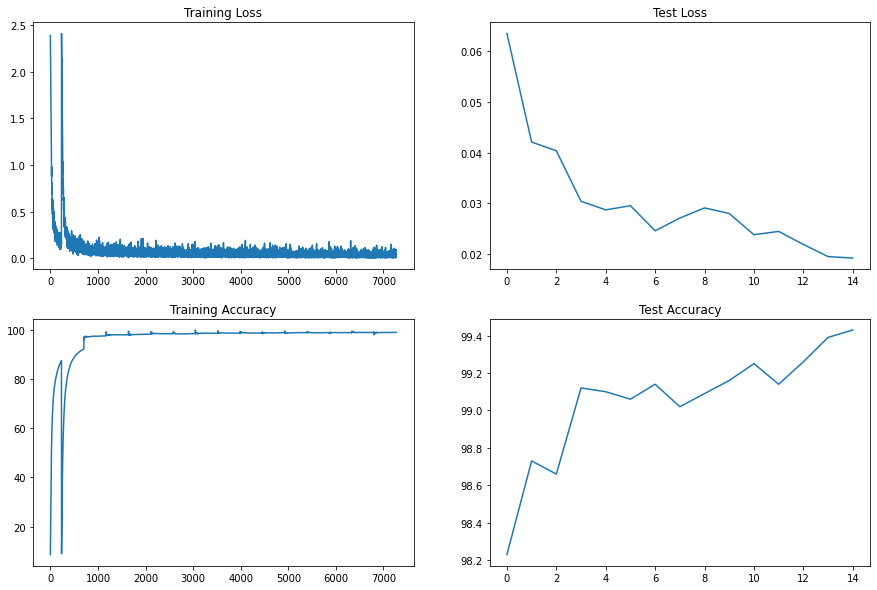

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# 2. Results:

**Note: The best & highest accuracies aren't written here, but the ones with less provoke to overfitting.**

*** We have achieved our desired target of 99.4 consistently, from EPOCHS 12 to till the end**

Top Accuracies: 

* Train    Test 

  99.58    99.46 
  
  99.49    99.31 
  
  99.56    98.37 
  
  99.47    99.27 
  
  

# 3. Analysis:

1. Here, the model right from first epoch started with good learning and learnt by improving its performance and provided best results from EPOCH 11.
 
3. Here, the augmentation has added.

In [40]:
!pip install colorama

In [17]:
from colorama import init,Fore, Back, Style 

print(Style.BRIGHT+Fore.BLACK +"Lets be happy for now of slimer_Trimmed model")

Lets be happy for now of slimer_Trimmed model


In [18]:
print("Done!")

Done!
